This notebook contains code necessary to create the figures for the recently submitted [paper](https://peerj.com/preprints/1431/). 


In [1]:
%matplotlib inline
from cualid import create_ids
import numpy as np
from difflib import get_close_matches
import pandas as pd
import seaborn as sns
import uuid
import itertools


In [170]:
def mutate_id(id_, n_mutations=3):
    cols = np.random.choice(range(len(id_)), size=(n_mutations), replace=False)
    mutated_id = list(id_)
    for col in cols:
        mutation = np.random.choice(list(' 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!'))
        while mutated_id[col] == mutation:
            mutation = np.random.choice(list(' 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!'))
        mutated_id[col] = mutation
    return ''.join(mutated_id)

def mutate_ids(ids_, n_mutations):
    mutated_ids = {}
    for id_ in ids_:
        mutated_ids[id_] = mutate_id(id_, n_mutations)
    return mutated_ids
        

def get_errors(n_ids=10, id_length=8, n_mutations=2, threshold=.6):
    
    hrids = [e[1] for e in create_ids(n_ids, id_length)]
    mutated_ids = mutate_ids(hrids, n_mutations)
    false_negative = 0
    false_positive = 0
    false = 0
    for correct_id, mutated_id in mutated_ids.items():
        fixed_id = get_close_matches(mutated_id, mutated_ids.keys(), n=1, cutoff=threshold)
        if len(fixed_id) < 1:
            false_negative += 1
            false += 1
        else:
            if fixed_id[0] != correct_id:
                false_positive += 1
                false += 1
                print(fixed_id, correct_id, mutated_id)
        
    return false_positive/n_ids, false_negative/n_ids, false/n_ids

In [193]:
#function for parallel stuff
def create_df(n_id, id_length, n_mutation, threshold):
    false_positive, false_negative, false = get_errors(n_id, id_length, n_mutation, threshold)
    return pd.DataFrame({"#CualIDs With Transcription Errors":[n_id], "CualID Length":[id_length], 
                                 "#Transcription Errors":[n_mutation], "Threshold":[threshold], 
                                 "Fraction Innacurate Correction":[false_positive], 
                                 "Fraction Uncorrectable":[false_negative],
                                 "Fraction Innacurate Correction or Uncorrectable":[false]})

In [194]:
n_ids = [1, 10, 100, 1000]
id_lengths = [7, 8, 9, 10]
n_mutations = [1, 2, 3]
thresholds = [.7]
iterations = 20

a = [n_ids, id_lengths, n_mutations, thresholds]
arguments = np.array(list(itertools.product(*a))*iterations).T

n_ids = list(map(int, arguments[0]))
id_lengths = list(map(int, arguments[1]))
n_mutations = list(map(int, arguments[2]))
thresholds = arguments[3]

In [195]:
from IPython.parallel import Client
clients = Client(profile='cual-id-conda')
clients[:].execute("import pandas as pd")
clients[:].execute("import numpy as np")
clients[:].execute("from cualid import create_ids")
clients[:].execute("from difflib import get_close_matches")
clients[:]['get_errors'] = get_errors
clients[:]['mutate_ids'] = mutate_ids
clients[:]['mutate_id'] = mutate_id

In [196]:
df = pd.DataFrame(columns=["#CualIDs With Transcription Errors", "CualID Length", "#Transcription Errors", "Threshold", "Fraction Innacurate Correction", "Fraction Uncorrectable", "Fraction Innacurate Correction or Uncorrectable"])
h = clients[:].map(create_df, n_ids, id_lengths, n_mutations, thresholds)
for i,r in enumerate(h):
    df = df.append(r)

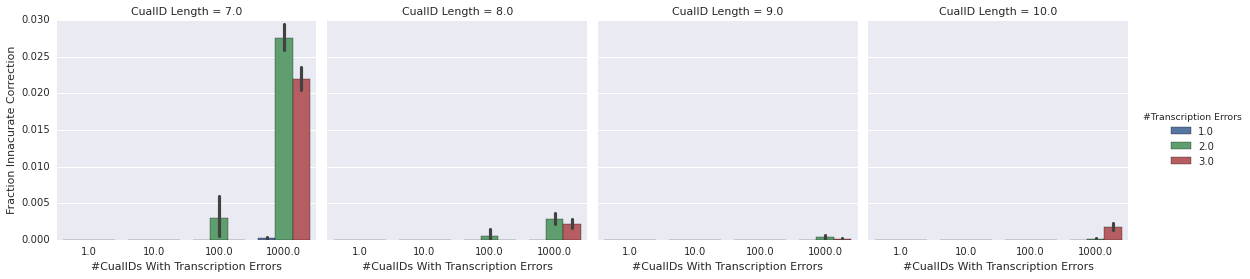

In [229]:
fig = sns.factorplot(x="#CualIDs With Transcription Errors", 
                     y="Fraction Innacurate Correction", 
                     hue="#Transcription Errors",
                     col="CualID Length", 
                     data=df, 
                     kind="bar");
fig.savefig('figure_2_false.pdf', dpi=300)

**(a)** The y-axis is the fraction of identifiers that were _incorrectly_ identified by cual-id. This is the rate of false positives

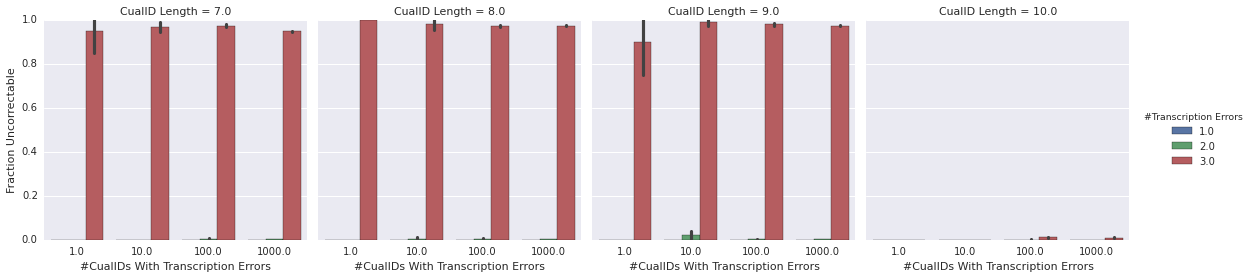

In [208]:
fig = sns.factorplot(x="#CualIDs With Transcription Errors", 
                     y="Fraction Uncorrectable", 
                     hue="#Transcription Errors",
                     col="CualID Length", 
                     data=df, 
                     kind="bar");
fig.savefig('figure_2_false.pdf', dpi=300)

**(b)** The fraction of Identifiers that were rejected as being to dissimilar to any of the identifiers in the reference set to be resolvable

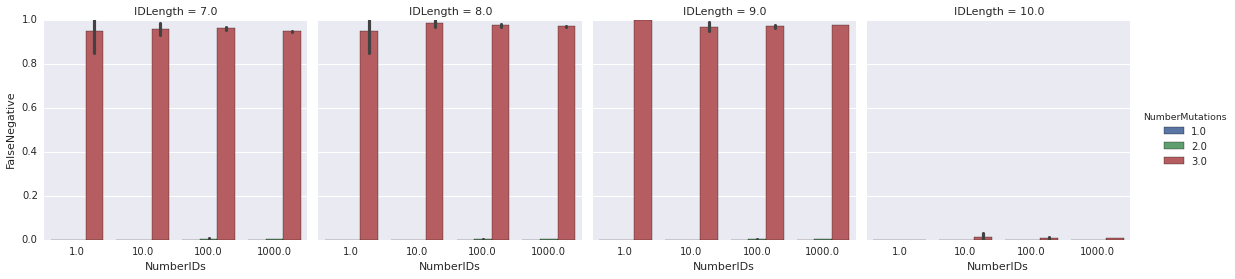

In [192]:
df_6 = df[df["Threshold"] == .7]
fig = sns.factorplot(x="NumberIDs", y="FalseNegative", hue="NumberMutations",
col="IDLength", data=df_6, kind="bar");
fig.savefig('figure_2_falseNegative.pdf', dpi=300)

**(c)** The fraction of incorrect identifiers that were either incorrectly associated with an identifier, or were unresolvable
